In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import numpy as np
import pickle
import umap
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

In [3]:
sns.set_style("ticks")
sns.set_context("paper")

In [4]:
def load_data(save_dir):
    textual_trajs = np.load(os.path.join(save_dir, "textual_trajs.npy"))
    visual_trajs = np.load(os.path.join(save_dir, "visual_trajs.npy"))
    task_ids = np.load(os.path.join(save_dir, "task_ids.npy"))
    seeds = np.load(os.path.join(save_dir, "seeds.npy"))

    with open(os.path.join(save_dir, "goal_objs.pkl"), "rb") as f:
        goal_objs = pickle.load(f)
    with open(os.path.join(save_dir, "distractors.pkl"), "rb") as f:
        distractors = pickle.load(f)

    return textual_trajs, visual_trajs, task_ids, seeds, goal_objs, distractors


def get_umap_embs(visual_trajs, textual_trajs, fit_target="visual"):
    reducer = umap.UMAP()
    if fit_target == "visual":
        reducer.fit(visual_trajs)
    else:
        reducer.fit(textual_trajs)

    visual_embs = reducer.transform(visual_trajs)
    textual_embs = reducer.transform(textual_trajs)

    return textual_embs, visual_embs

In [5]:
JUST_CLIPT = False

In [6]:
clipt_save_dir = "../outputs/babyai/clipt-embs/"
if not JUST_CLIPT:
    cclipt_save_dir = "../outputs/babyai/cclipt-embs/"

In [7]:
clipt_data = load_data(clipt_save_dir)
if not JUST_CLIPT:
    cclipt_data = load_data(cclipt_save_dir)

pygame 2.5.0 (SDL 2.28.0, Python 3.8.16)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [8]:
clipt_textual_trajs, clipt_visual_trajs, clipt_task_ids, _, clipt_goals = clipt_data[:5]
if not JUST_CLIPT:
    (
        cclipt_textual_trajs,
        cclipt_visual_trajs,
        cclipt_task_ids,
        _,
        cclipt_goals,
    ) = cclipt_data[:5]

In [9]:
clipt_goal_colors = np.array([goal.color for goal in clipt_goals])
clipt_goal_types = np.array([goal.type for goal in clipt_goals])

if not JUST_CLIPT:
    cclipt_goal_colors = np.array([goal.color for goal in cclipt_goals])
    cclipt_goal_types = np.array([goal.type for goal in cclipt_goals])

In [10]:
type_to_color = {"key": "gold", "box": "black", "ball": "purple"}

In [11]:
clipt_goal_types_colors = np.vectorize(type_to_color.get)(clipt_goal_types)
if not JUST_CLIPT:
    cclipt_goal_types_colors = np.vectorize(type_to_color.get)(cclipt_goal_types)

In [12]:
# takes a while :) (~3 mins)
clipt_textual_embs, clipt_visual_embs = get_umap_embs(
    clipt_visual_trajs, clipt_textual_trajs
)
if not JUST_CLIPT:
    cclipt_textual_embs, cclipt_visual_embs = get_umap_embs(
        cclipt_visual_trajs, cclipt_textual_trajs
    )

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [13]:
id_to_env = [
    # go to the key
    "Custom-GoToObjK-v0",
    # go to the box
    "Custom-GoToObjBx-v0",
    # go to the ball
    "Custom-GoToObjBl-v0",
    # go to the red object
    "Custom-GoToColorR-v0",
    # go to the green object
    "Custom-GoToColorG-v0",
    # go to the blue object
    "Custom-GoToColorB-v0",
]
env_to_id = {task: i for i, task in enumerate(id_to_env)}
env_to_task = {
    "Custom-GoToObjK-v0": "Go to the key",
    "Custom-GoToObjBx-v0": "Go to the box",
    "Custom-GoToObjBl-v0": "Go to the ball",
    "Custom-GoToColorR-v0": "Go to the red object",
    "Custom-GoToColorG-v0": "Go to the green object",
    "Custom-GoToColorB-v0": "Go to the blue object",
}
id_to_task = [env_to_task[env] for env in id_to_env]
env_to_color = {
    "Custom-GoToObjK-v0": "gold",
    "Custom-GoToObjBx-v0": "black",
    "Custom-GoToObjBl-v0": "purple",
    "Custom-GoToColorR-v0": "red",
    "Custom-GoToColorG-v0": "green",
    "Custom-GoToColorB-v0": "blue",
}
id_to_color = [env_to_color[env] for env in id_to_env]
id_to_color_map = {i: color for i, color in enumerate(id_to_color)}

In [14]:
# task_ids is the same for both clipt and cclipt
task_id_colors = np.vectorize(id_to_color_map.get)(clipt_task_ids)

In [15]:
def plot_one_task_id(clipt_visual_embs, clipt_textual_embs, task_id_colors):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(5.09, 2.54), dpi=500)

    scatter_kwargs = {"s": 0.5, "color": task_id_colors, "alpha": 0.5}

    ax1.scatter(clipt_visual_embs[:, 0], clipt_visual_embs[:, 1], **scatter_kwargs)
    ax1.set_title("Visual")
    ax1.set_ylabel("CLIPT")
    ax2.scatter(clipt_textual_embs[:, 0], clipt_textual_embs[:, 1], **scatter_kwargs)
    ax2.set_title("Textual")

    legend_elements = []
    for task_id in range(len(id_to_env)):
        label = id_to_task[task_id]
        legend_elements.append(
            plt.Line2D(
                [0],
                [0],
                marker="o",
                color="w",
                markerfacecolor=id_to_color[task_id],
                markersize=10,
                label=label,
            )
        )

    ax1.legend(handles=legend_elements)

    f.set_tight_layout(True)
    plt.show()


def plot_both_task_id(
    clipt_visual_embs,
    clipt_textual_embs,
    cclipt_visual_embs,
    cclipt_textual_embs,
    task_id_colors,
):
    f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(5.09, 5.09), dpi=500)

    scatter_kwargs = {"s": 0.5, "color": task_id_colors, "alpha": 0.5}

    ax1.scatter(clipt_visual_embs[:, 0], clipt_visual_embs[:, 1], **scatter_kwargs)
    ax1.set_title("Visual")
    ax1.set_ylabel("CLIPT")
    ax2.scatter(clipt_textual_embs[:, 0], clipt_textual_embs[:, 1], **scatter_kwargs)
    ax2.set_title("Textual")

    ax3.scatter(cclipt_visual_embs[:, 0], cclipt_visual_embs[:, 1], **scatter_kwargs)
    ax3.set_title("Visual")
    ax3.set_ylabel("CCLIPT-2P")
    ax4.scatter(cclipt_textual_embs[:, 0], cclipt_textual_embs[:, 1], **scatter_kwargs)
    ax4.set_title("Textual")

    legend_elements = []
    for task_id in range(len(id_to_env)):
        label = id_to_task[task_id]
        legend_elements.append(
            plt.Line2D(
                [0],
                [0],
                marker="o",
                color="w",
                markerfacecolor=id_to_color[task_id],
                markersize=10,
                label=label,
            )
        )

    ax1.legend(handles=legend_elements)

    f.set_tight_layout(True)
    plt.show()

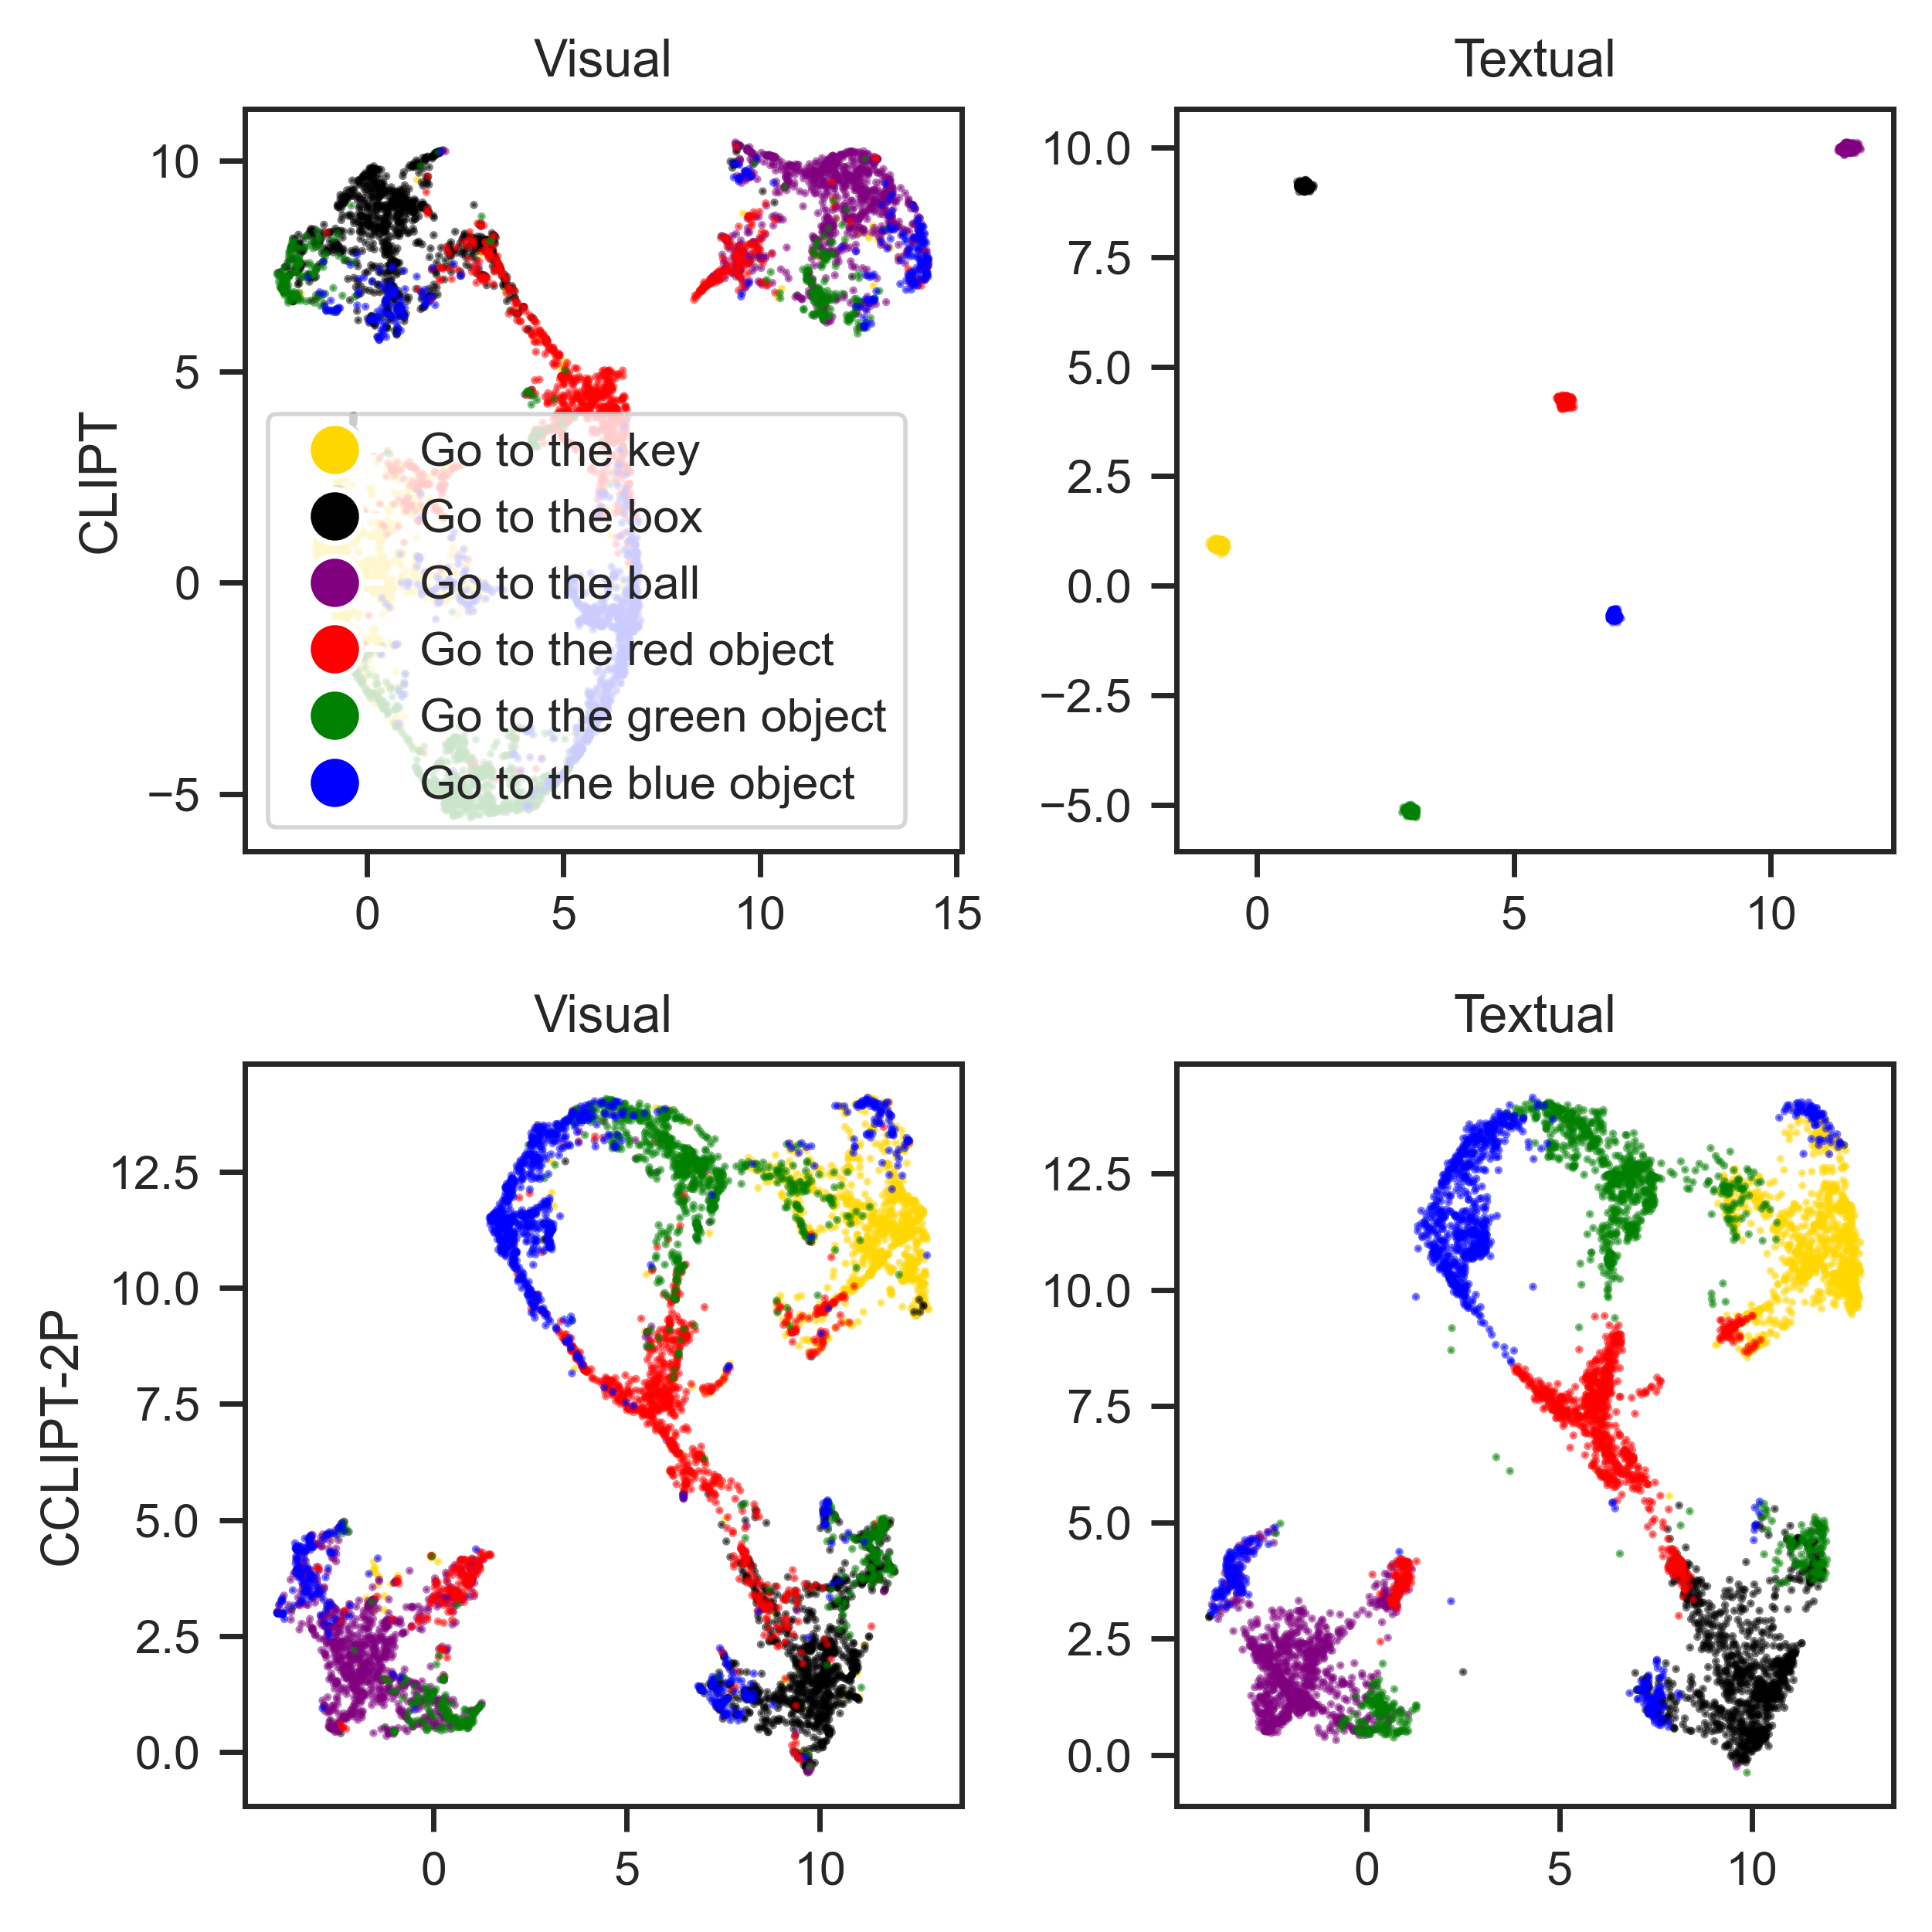

In [16]:
if not JUST_CLIPT:
    plot_both_task_id(
        clipt_visual_embs,
        clipt_textual_embs,
        cclipt_visual_embs,
        cclipt_textual_embs,
        task_id_colors,
    )
else:
    plot_one_task_id(clipt_visual_embs, clipt_textual_embs, task_id_colors)

In [17]:
def plot_one_goals(
    clipt_visual_embs,
    clipt_textual_embs,
    clipt_goal_colors,
    clipt_goal_types_colors,
):
    f, (ax1, ax2) = plt.subplots(
        1, 2, figsize=(5.09, 2.54), dpi=500, sharey=True, layout="constrained"
    )

    font = {
        "fontname": "Times New Roman",
        "size": 10,
        "math_fontfamily": "stix",
    }

    clipt_scatter_kwargs = {
        "s": 5,
        "color": clipt_goal_colors,
        "edgecolors": clipt_goal_types_colors,
        "linewidths": 0.5,
    }

    ax1.scatter(
        clipt_visual_embs[:, 0], clipt_visual_embs[:, 1], **clipt_scatter_kwargs
    )
    ax1.set_title("Visual", **font)
    ax1.set_ylabel("CLIPT", **font)
    ax2.scatter(
        clipt_textual_embs[:, 0], clipt_textual_embs[:, 1], **clipt_scatter_kwargs
    )
    ax2.set_title("Textual", **font)

    legend_elements = []
    for gtype in {"key", "box", "ball"}:
        for gcolor in {"red", "green", "blue"}:
            label = f"Goal: {gcolor} {gtype}"

            legend_elements.append(
                plt.Line2D(
                    [0],
                    [0],
                    marker="o",
                    color="w",
                    markerfacecolor=gcolor,
                    markeredgecolor=type_to_color[gtype],
                    markersize=3,
                    markeredgewidth=0.75,
                    label=label,
                )
            )

    ax2.legend(
        handles=legend_elements, prop={"size": 6, "family": "serif"}, loc=(0.175, 0.025)
    )

    for ax in [ax1, ax2]:
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.tick_params(width=0.5)

    # f.set_tight_layout(True)
    plt.savefig(
        "../outputs/babyai/images/clipt-umap-para.pdf",
        bbox_inches="tight",
        pad_inches=0.01,
    )
    plt.show()


def plot_both_goals(
    clipt_visual_embs,
    clipt_textual_embs,
    cclipt_visual_embs,
    cclipt_textual_embs,
    clipt_goal_colors,
    clipt_goal_types_colors,
    cclipt_goal_colors,
    cclipt_goal_types_colors,
):
    f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(
        2,
        2,
        figsize=(5.09, 5.09),
        dpi=500,
        layout="constrained",
        sharey="row",
        sharex="col",
    )
    font = {
        "fontname": "Times New Roman",
        "size": 10,
        "math_fontfamily": "stix",
    }

    clipt_scatter_kwargs = {
        "s": 5,
        "color": clipt_goal_colors,
        "edgecolors": clipt_goal_types_colors,
        # "alpha": 0.5,
        "linewidths": 0.5,
    }

    ax1.scatter(
        clipt_visual_embs[:, 0], clipt_visual_embs[:, 1], **clipt_scatter_kwargs
    )
    ax1.set_title("Visual", **font)
    ax1.set_ylabel("CLIPT", **font)
    ax2.scatter(
        clipt_textual_embs[:, 0], clipt_textual_embs[:, 1], **clipt_scatter_kwargs
    )
    ax2.set_title("Textual", **font)

    cclipt_scatter_kwargs = {
        "s": 5,
        "color": cclipt_goal_colors,
        "edgecolors": cclipt_goal_types_colors,
        "linewidths": 0.5,
    }
    ax3.scatter(
        cclipt_visual_embs[:, 0], cclipt_visual_embs[:, 1], **cclipt_scatter_kwargs
    )
    ax3.set_ylabel("CCLIPT-2P", **font)
    ax4.scatter(
        cclipt_textual_embs[:, 0], cclipt_textual_embs[:, 1], **cclipt_scatter_kwargs
    )

    legend_elements = []
    for gtype in {"key", "box", "ball"}:
        for gcolor in {"red", "green", "blue"}:
            label = f"Goal: {gcolor} {gtype}"

            legend_elements.append(
                plt.Line2D(
                    [0],
                    [0],
                    marker="o",
                    color="w",
                    markerfacecolor=gcolor,
                    markeredgecolor=type_to_color[gtype],
                    markersize=3,
                    markeredgewidth=0.75,
                    label=label,
                    linewidth=0,
                )
            )

    ax1.legend(handles=legend_elements, prop={"size": 6, "family": "serif"})

    for ax in [ax1, ax2, ax3, ax4]:
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.tick_params(width=0.5)

    # f.set_tight_layout(True)
    plt.savefig(
        "../outputs/babyai/images/clipt-umap.pdf",
        bbox_inches="tight",
        pad_inches=0.01,
    )
    plt.show()

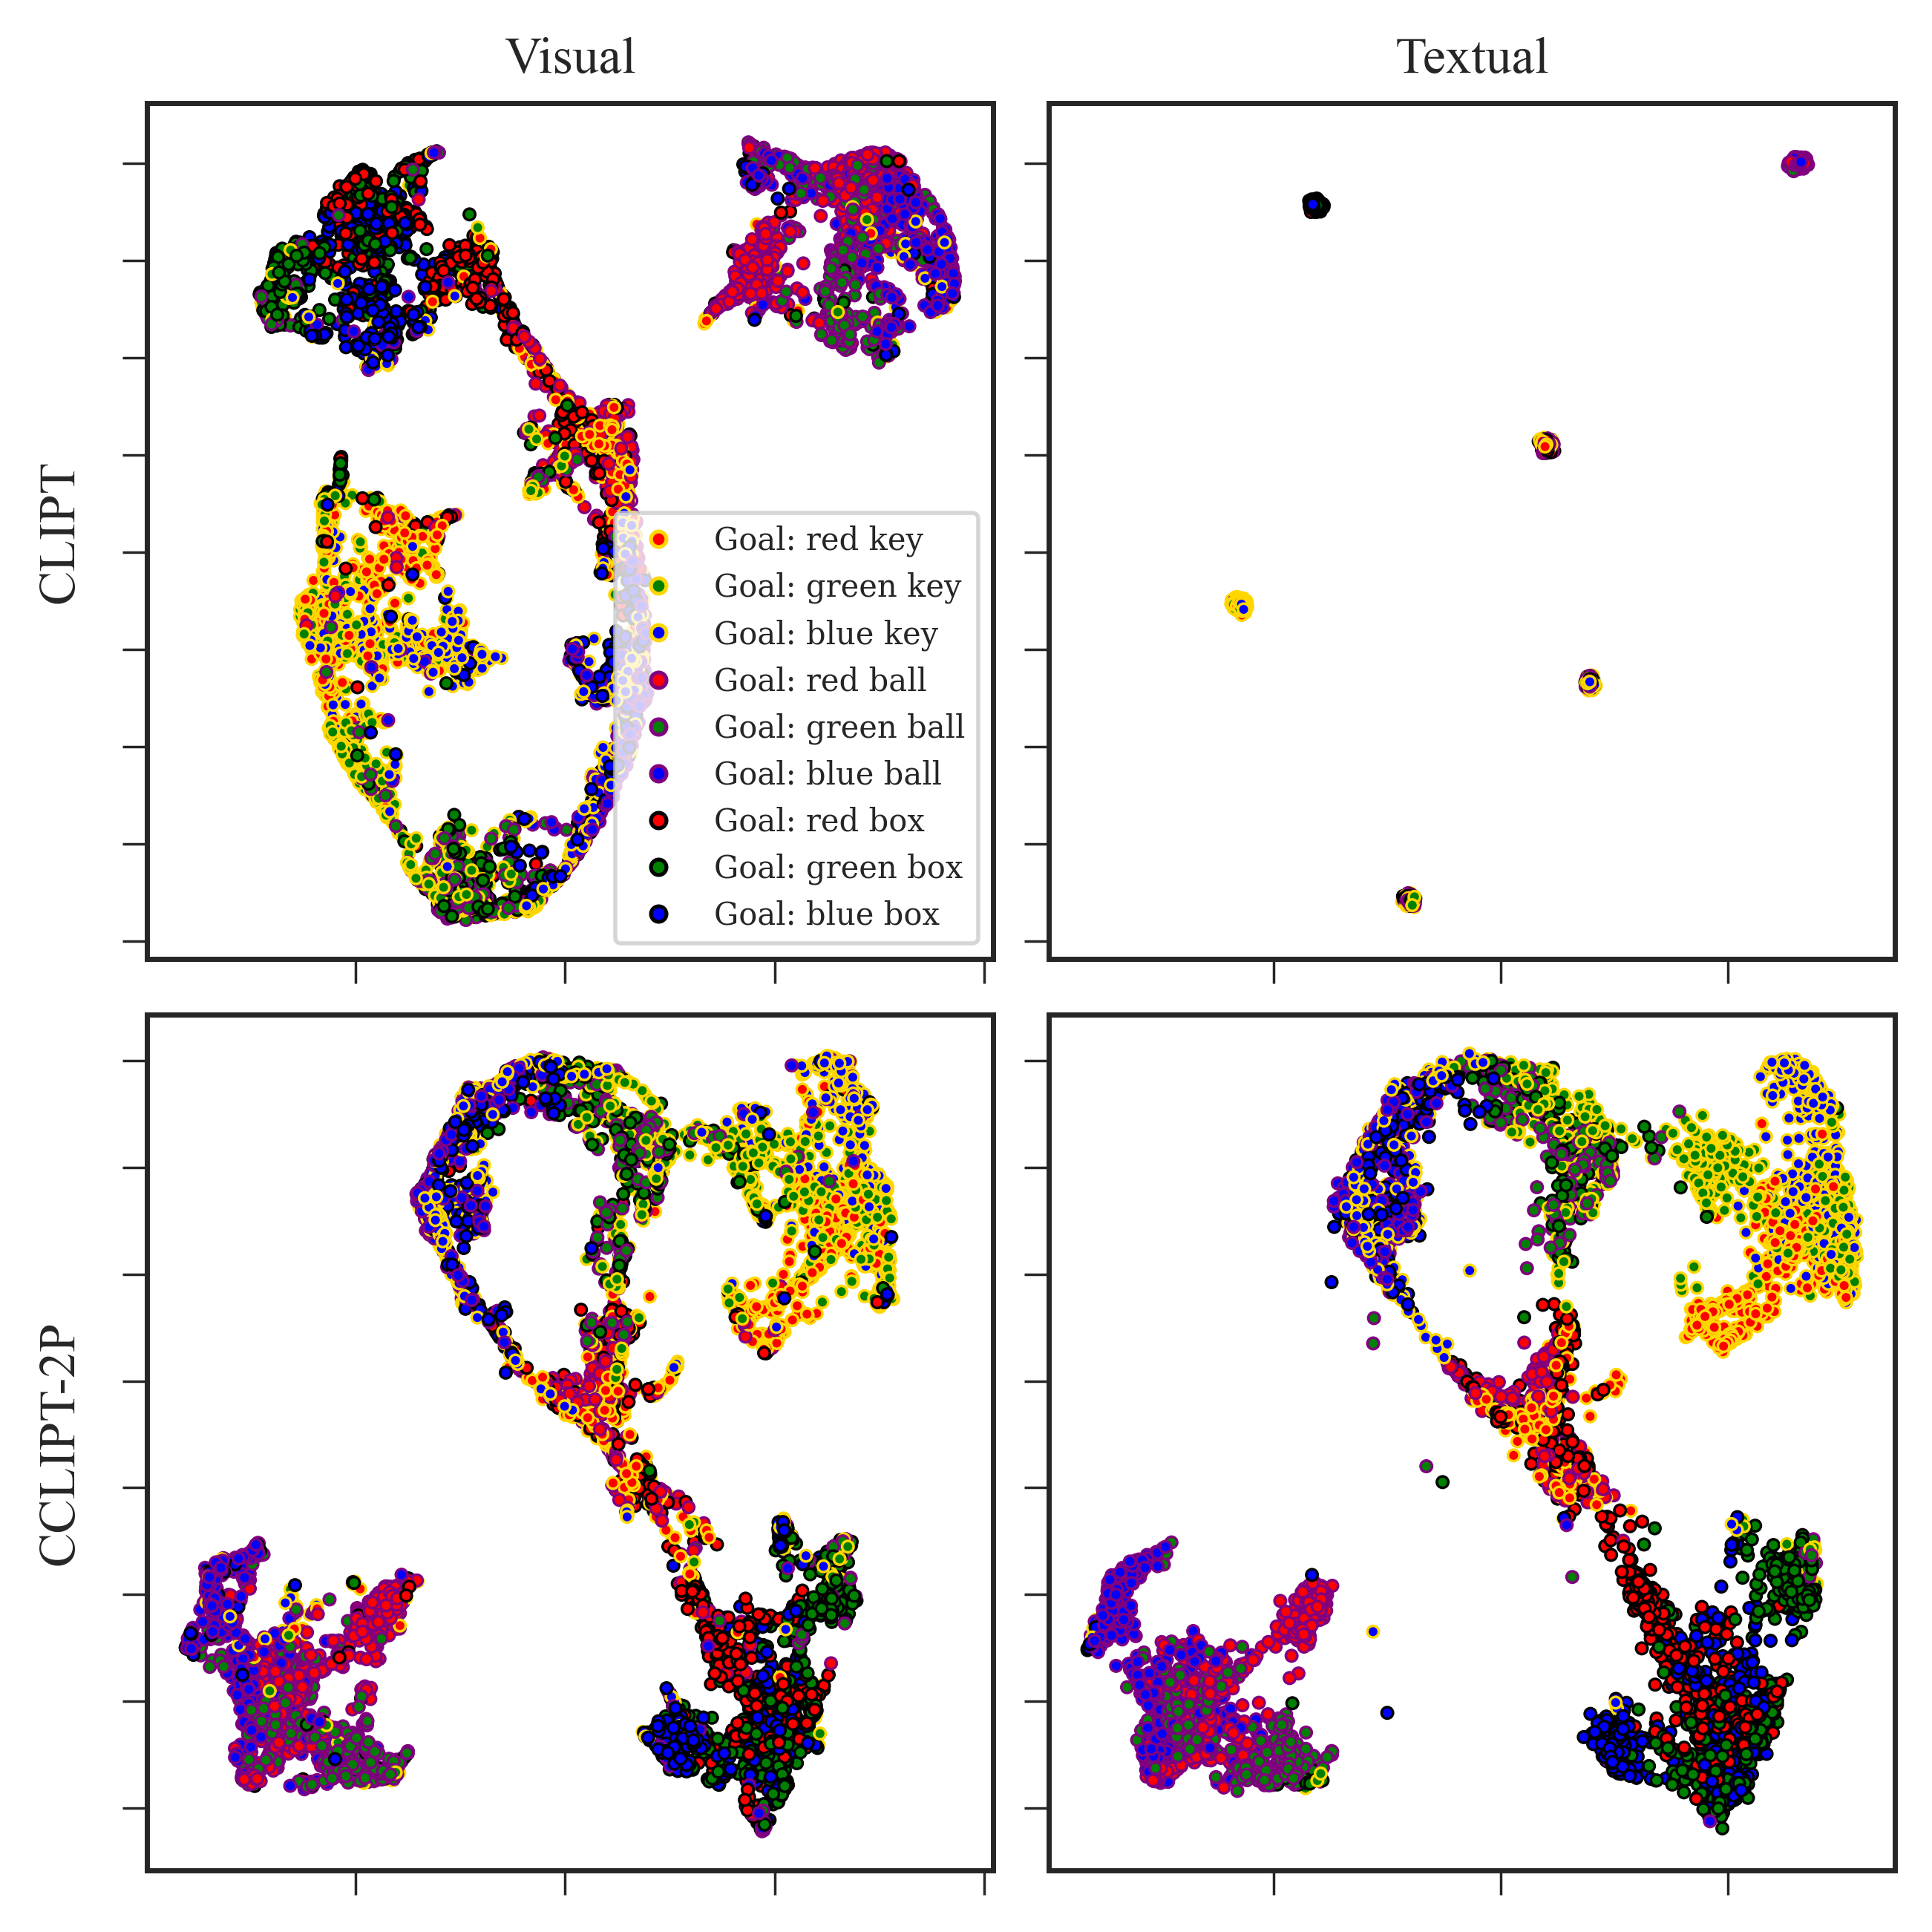

In [18]:
if not JUST_CLIPT:
    plot_both_goals(
        clipt_visual_embs,
        clipt_textual_embs,
        cclipt_visual_embs,
        cclipt_textual_embs,
        clipt_goal_colors,
        clipt_goal_types_colors,
        cclipt_goal_colors,
        cclipt_goal_types_colors,
    )
else:
    plot_one_goals(
        clipt_visual_embs,
        clipt_textual_embs,
        clipt_goal_colors,
        clipt_goal_types_colors,
    )